# Image analysis for control charts for Power Bed Laser Fusion

## Data manipolation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

,t,x,y,z,layer_id,sensor0,sensor1,temp,track_id,track_orient,pos_rel,t_rel
0,127875690.0,38.119,-54.480,8.96,224,800.0,805.0,1580.9,0,271,0.00000,0.0
1,127875700.0,38.118,-54.489,8.96,224,807.0,801.0,1596.0,0,271,0.00721,10.0
2,127875710.0,38.119,-54.498,8.96,224,813.0,809.0,1593.2,0,271,0.01442,20.0
3,127875720.0,38.119,-54.508,8.96,224,813.0,824.0,1573.0,0,271,0.02163,30.0
4,127875730.0,38.121,-54.515,8.96,224,820.0,825.0,1581.0,0,271,0.02884,40.0


Generate a temperature matrix

In [2]:
# first pivots and then crops
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [3]:
digits_round = 1
x_range = (27, 37)
y_range = (-66, -56)
batch1_id = [224, 225, 226, 227, 228]
batch1 = generate_temperature_matrices_v1(df, batch1_id, x_range, y_range, digits_round)

C:\Users\Utente\AppData\Local\Temp\ipykernel_2872\1335970279.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
C:\Users\Utente\AppData\Local\Temp\ipykernel_2872\1335970279.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


Plot to see if it works:

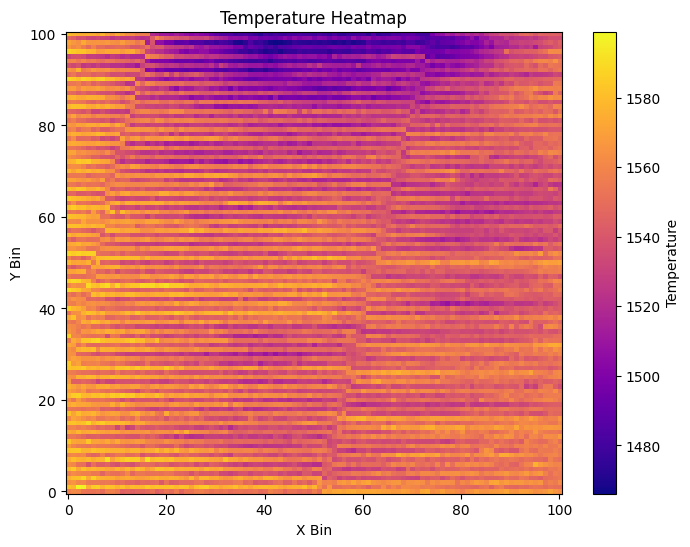

In [4]:
plt.figure(figsize=(8, 6))
plt.imshow(batch1[4], origin='lower', cmap='plasma', aspect='auto')
plt.colorbar(label='Temperature')
plt.title('Temperature Heatmap')
plt.xlabel('X Bin')
plt.ylabel('Y Bin')
plt.show()

## Apply PCA and compute Hotelling's T²

Reshape the batch for PCA

In [5]:
J, M, N = batch1.shape
p = M * N

# Reshape: (J, M, N) → (p, J)
X = batch1.reshape(J, -1).T  # shape: (p, J)

In [6]:
from sklearn.decomposition import PCA
import numpy as np

# Apply PCA, retaining 80% variance
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X)

# Hotelling's T² calculation
T2 = np.sum((X_pca / np.std(X_pca, axis=0))**2, axis=1)
T2_image = T2.reshape(M, N)

## Apply k-means clustering

In [7]:
from sklearn.cluster import KMeans

T2_flat = T2_image.flatten().reshape(-1, 1)
kmeans = KMeans(n_clusters=3, n_init=100, random_state=42)
labels = kmeans.fit_predict(T2_flat)
clustered_image = labels.reshape(M, N)

### Find K

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

def compute_ssw(T2_flat, max_k=5):
    ssw = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=100, random_state=42)
        labels = kmeans.fit_predict(T2_flat)
        centers = kmeans.cluster_centers_
        ssw_k = sum((T2_flat[i] - centers[labels[i]])**2 for i in range(len(T2_flat)))
        ssw.append(ssw_k.sum())
    return ssw

def compute_elbow_point(ssw):
    # line from point 1 to point K
    k_vals = np.arange(1, len(ssw) + 1)
    line_start = np.array([1, ssw[0]])
    line_end = np.array([len(ssw), ssw[-1]])

    def distance_to_line(x, y, start, end):
        # point-line distance formula
        numerator = np.abs((end[1] - start[1]) * x - (end[0] - start[0]) * y +
                           end[0]*start[1] - end[1]*start[0])
        denominator = np.sqrt((end[1] - start[1])**2 + (end[0] - start[0])**2)
        return numerator / denominator

    distances = [distance_to_line(k, ssw_val, line_start, line_end)
                 for k, ssw_val in zip(k_vals, ssw)]

    best_k = k_vals[np.argmax(distances)]
    return best_k, distances

# Flatten T² image
T2_flat = T2_image.flatten().reshape(-1, 1)

# Run SSW and elbow detection
ssw = compute_ssw(T2_flat, max_k=5)
best_k, distances = compute_elbow_point(ssw)

# Plot elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 6), ssw, 'o-', label='SSW(k)')
plt.xlabel('Number of Clusters k')
plt.ylabel('Sum of Squared Distances (SSW)')
plt.title(f'Elbow Method - Suggested k = {best_k}')
plt.axvline(best_k, color='r', linestyle='--', label='Elbow Point')
plt.legend()
plt.grid(True)
plt.show()

## Plot

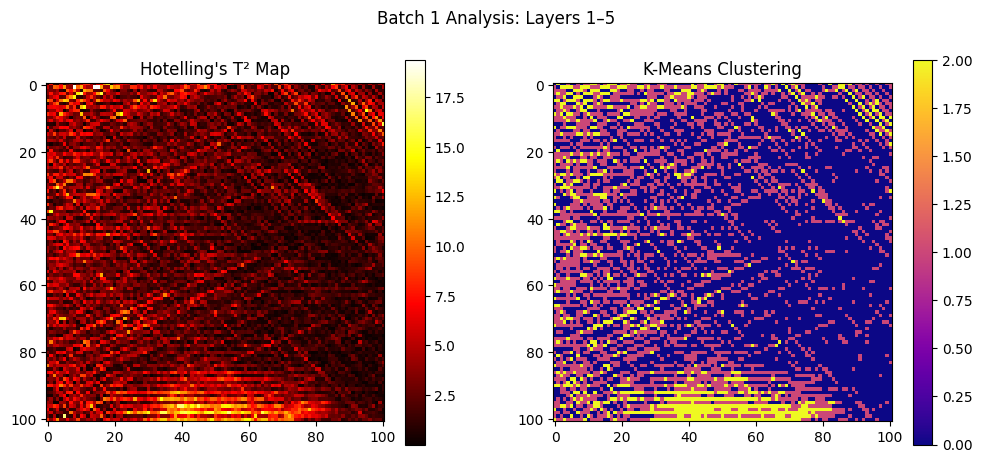

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.suptitle("Batch 1 Analysis: Layers 1–5")

plt.subplot(1, 2, 1)
plt.imshow(T2_image, cmap='hot')
plt.title("Hotelling's T² Map")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(clustered_image, cmap='plasma')
plt.title("K-Means Clustering")
plt.colorbar()
plt.show()

Checking the layers to see if it matches

## Control chart with max T2

In [10]:
digits_round = 2
x_range = (27, 37)
y_range = (-66, -56)
batch1_id = [224, 225, 226, 227, 228]
batch2_id = [324, 325, 326, 327, 328]
batch3_id = [424, 425, 426, 427, 428]
batch4_id = [524, 525, 526, 527, 528]
batch5_id = [569, 570, 571, 572, 573]
batch1 = generate_temperature_matrices_v1(df, batch1_id, x_range, y_range, digits_round)
batch2 = generate_temperature_matrices_v1(df, batch2_id, x_range, y_range, digits_round)
batch3 = generate_temperature_matrices_v1(df, batch3_id, x_range, y_range, digits_round)
batch4 = generate_temperature_matrices_v1(df, batch4_id, x_range, y_range, digits_round)
batch5 = generate_temperature_matrices_v1(df, batch5_id, x_range, y_range, digits_round)
batches = [batch1,batch2,batch3,batch4,batch5]

C:\Users\Utente\AppData\Local\Temp\ipykernel_2872\1335970279.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
C:\Users\Utente\AppData\Local\Temp\ipykernel_2872\1335970279.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


Collect T² statistics across batches

max(T²) How extreme the hottest point is.

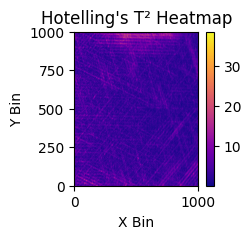

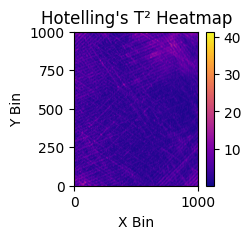

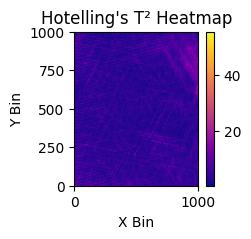

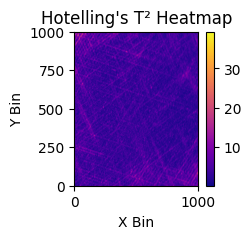

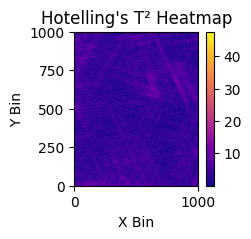

[38.51335516467944, 41.44787209484457, 55.81493819477892, 39.407524318481876, 47.55879022514748]


In [11]:
T2_max_values = []

for batch in batches:
    J, M, N = batch.shape
    X = batch.reshape(J, -1).T
    pca = PCA(n_components=0.80)
    X_pca = pca.fit_transform(X)
    T2 = np.sum((X_pca / np.std(X_pca, axis=0))**2, axis=1)
    T2_image = T2.reshape(M, N)

    plt.figure(figsize=(2, 2))
    plt.imshow(T2_image, origin='lower', cmap='plasma', aspect='auto')
    plt.colorbar()
    plt.title('Hotelling\'s T² Heatmap')
    plt.xlabel('X Bin')
    plt.ylabel('Y Bin')
    plt.show()

    T2_max = np.max(T2_image)
    T2_max_values.append(T2_max)

print(T2_max_values)

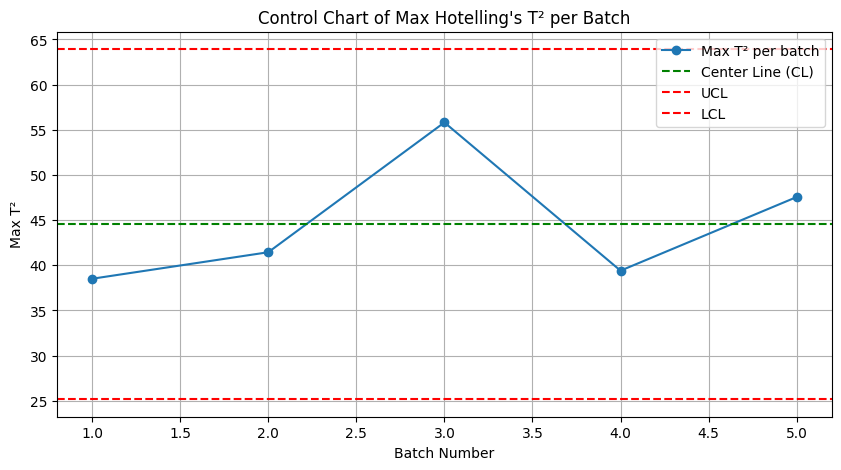

In [12]:
import matplotlib.pyplot as plt
import numpy as np

T2_max_values = np.array(T2_max_values)
CL = np.mean(T2_max_values)
sigma = np.std(T2_max_values)
UCL = CL + 3 * sigma
LCL = max(CL - 3 * sigma, 0)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(T2_max_values) + 1), T2_max_values, marker='o', label='Max T² per batch')
plt.axhline(CL, color='green', linestyle='--', label='Center Line (CL)')
plt.axhline(UCL, color='red', linestyle='--', label='UCL')
plt.axhline(LCL, color='red', linestyle='--', label='LCL')
plt.title("Control Chart of Max Hotelling's T² per Batch")
plt.xlabel("Batch Number")
plt.ylabel("Max T²")
plt.legend()
plt.grid(True)
plt.show()

## Control chart Based on Defect Area

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

def compute_defect_area(batch, n_clusters=3):
    J, M, N = batch.shape
    X = batch.reshape(J, -1).T

    # PCA
    pca = PCA(n_components=0.80)
    X_pca = pca.fit_transform(X)
    T2 = np.sum((X_pca / np.std(X_pca, axis=0))**2, axis=1)
    T2_image = T2.reshape(M, N)

    # Clustering
    T2_flat = T2_image.flatten().reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=42)
    labels = kmeans.fit_predict(T2_flat)

    # Determine which cluster is the 'defect cluster' (highest average T²)
    cluster_means = [T2_flat[labels == i].mean() for i in range(n_clusters)]
    defect_cluster_id = np.argmax(cluster_means)

    # Count pixels in defect cluster (area)
    defect_area = np.sum(labels == defect_cluster_id)

    return defect_area


In [ ]:
defect_areas = [compute_defect_area(batch) for batch in batches]
print(defect_areas)

[84786, 101798, 88640, 89572, 99992]


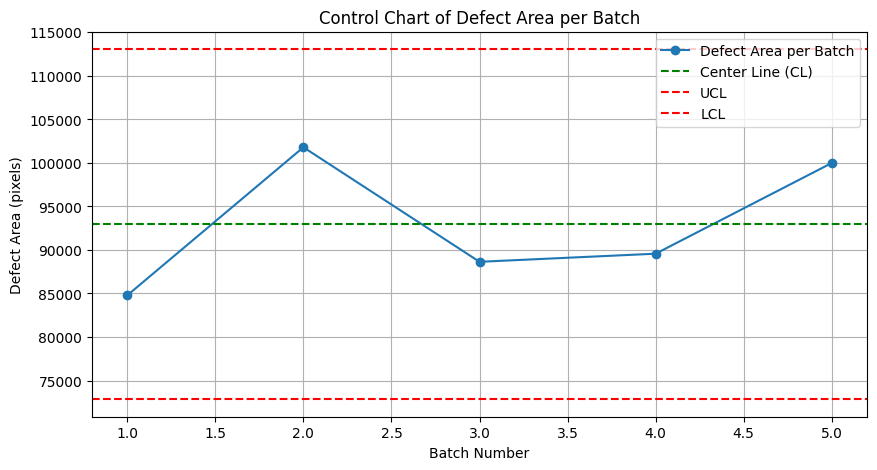

In [15]:
defect_areas = np.array(defect_areas)
CL = np.mean(defect_areas)
sigma = np.std(defect_areas)
UCL = CL + 3 * sigma
LCL = max(CL - 3 * sigma, 0)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(defect_areas) + 1), defect_areas, marker='o', label='Defect Area per Batch')
plt.axhline(CL, color='green', linestyle='--', label='Center Line (CL)')
plt.axhline(UCL, color='red', linestyle='--', label='UCL')
plt.axhline(LCL, color='red', linestyle='--', label='LCL')
plt.title("Control Chart of Defect Area per Batch")
plt.xlabel("Batch Number")
plt.ylabel("Defect Area (pixels)")
plt.legend()
plt.grid(True)
plt.show()